In [1]:
import pandas as pd
from os.path import join, isdir

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from icecream import ic
from src.utils import variant_utils as vu
from glob import glob
from itertools import product
from collections import defaultdict
from tqdm.notebook import tqdm
import pickle

from mplh.color_utils import create_color_df_v02

In [2]:
indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/mt_clones_thresh"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/anno_mt_clones_thresh"
# need to change se_meta to annotation input
se_meta = "/mnt/md0/isshamie/Projects/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_A2_black/annotation_clones/se_cells_meta_labels.tsv"

mt_genome="/data/Mito_Trace/data/external/GRCh38_MT_blacklist/chrM.fasta"
N_DONORS=2

## Parameters:
# af thresholds
# coverage threshold
# other_af thresholds
# number of cells / fraction cells
# number of other cells / fraction other cells
af_t = 0.1
oth_af_t = 0.1
cov_t = 2
oth_cov_t = 2
ncells = 5
oth_ncells = 0.6
mean_pos_cov = 0

In [3]:
cells_dir=join(indir, "cells")

In [4]:
#samples = samples.split(",")

### Smaller params

In [5]:
labels_df = pd.read_csv(se_meta,sep="\t").set_index("ID")
print(labels_df.shape)

labels_df = labels_df[~(labels_df["donor"]=='None')]
print(labels_df.shape)
labels_df.head()

(18672, 39)
(16639, 39)


,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,...,ATAC_snn_res.0.8,seurat_clusters,nCount_RNA,nFeature_RNA,Row.names,lineage,donor,condition,name,cluster_labels
ID,,,,,,,,,,,,,,,,,,,,,
AAACGAAAGAATCAGT-1_Control,Control,1972,1972,6432,1259,31,19,266,1066,3791,...,6,6,2211,1942,Control_AAACGAAAGAATCAGT-1,4,1,Control,1_4,eosonophil
AAACGAAAGCATACCT-1_Control,Control,2674,2674,11858,1937,51,34,549,3102,6185,...,7,7,3311,2750,Control_AAACGAAAGCATACCT-1,30,1,Control,1_30,MPP/CMP/GMP C
AAACGAAAGCGAGAAA-1_Control,Control,1939,1939,7365,1097,25,27,275,2184,3757,...,7,7,2112,1838,Control_AAACGAAAGCGAGAAA-1,15,0,Control,0_15,MPP/CMP/GMP C
AAACGAAAGTACAGAT-1_Control,Control,862,862,4095,861,16,16,230,771,2201,...,4,4,1441,1317,Control_AAACGAAAGTACAGAT-1,9,0,Control,0_9,erythroid
AAACGAAAGTACAGTA-1_Control,Control,1775,1775,8088,1091,27,27,369,2157,4417,...,6,6,2385,2085,Control_AAACGAAAGTACAGTA-1,17,1,Control,1_17,eosonophil


In [6]:
def fill_mt_bin(curr_pos, curr_cells):
    print(curr_pos.name)
    curr_pos.loc[curr_cells[curr_pos.name]["other_cells"]] = 0
    curr_pos.loc[curr_cells[curr_pos.name]["clone_cells"]] = 1
    return curr_pos

In [7]:
bin_d = {}
for d in range(N_DONORS): 
    curr_f = join(cells_dir, f"don.{d}_af.{af_t}_othaf.{oth_af_t}_cov.{cov_t}_othcov.{oth_cov_t}.p")
    curr_cells = pickle.load(open(curr_f,'rb'))
    params_results = pd.read_csv(join(indir, f"donor_{d}_thresh_results.tsv"), sep="\t")    


    curr_p = params_results.loc[(params_results["af"]==af_t) &
                       (params_results["oth_af"]==oth_af_t) &
                       (params_results["cov"]==cov_t) &
                       (params_results["oth_cov"]==oth_cov_t) &
                       (params_results["ncells"]==ncells) &
                       (params_results["oth_ncells"]==oth_ncells) &
                       (params_results["mean_cov"]==mean_pos_cov)]
    assert(len(curr_p)==1)
    
    ## Construct a binary cell-by-variant matrix for the kept variants. 
    ## Can add N/A if not in oth cells
    curr_vars = curr_p.iloc[0]["Variants"].split(";")

    all_cells = set()
    for x in curr_cells:
        all_cells = all_cells.union(set(curr_cells[x]["clone_cells"])) 
        all_cells = all_cells.union(set(curr_cells[x]["other_cells"])) 

    mt_bin = pd.DataFrame(index = all_cells, columns=curr_vars)
    bin_d[d] = mt_bin.apply(fill_mt_bin, curr_cells=curr_cells,axis=0)


curr_vars 36
10463C
10559G
11251G
11453A
11719A
11812G
13368A
14233G
14674C
14905A
150T
152C
15452A
15607G
15928A
16129A
16294T
16296T
16304C
16519C
1888A
1949A
2623G
3109C
3244A
4117C
4216C
4917G
5147A
5442C
5580C
709A
8697A
8743A
930A
9899C
curr_vars 27
10397G
10589A
11453A
11761T
13188T
146C
15297C
15497A
16129A
16355T
16362C
1949A
196C
204C
2442C
2623G
3109C
3244A
3847C
5442C
5581G
58C
64T
7598A
827G
8292A
8461T


## Group by cluster_labels and donor and get number of cells

In [8]:
def get_mt_ncells(curr_df, bin_d):
    lab, don = curr_df.name
    curr_bin = bin_d[int(don)]
    out = curr_bin.loc[curr_df.index].sum(axis=0)
    out.name = "Variants"
    return curr_bin.loc[curr_df.index].sum(axis=0)
    
lin_mt_ncells = labels_df.groupby(["cluster_labels", "donor"]).apply(get_mt_ncells, bin_d)
lin_mt_ncells = lin_mt_ncells.reset_index().rename({"level_2":"Variants"}, axis=1)
lin_mt_ncells

,cluster_labels,donor,Variants,0
0,CLP,0,10463C,1
1,CLP,0,10559G,4
2,CLP,0,11251G,1
3,CLP,0,11453A,3
4,CLP,0,11719A,1
...,...,...,...,...
877,neutrophil B,1,64T,10
878,neutrophil B,1,7598A,17
879,neutrophil B,1,827G,12
880,neutrophil B,1,8292A,17


# Plot variants-by-cluster heatmap

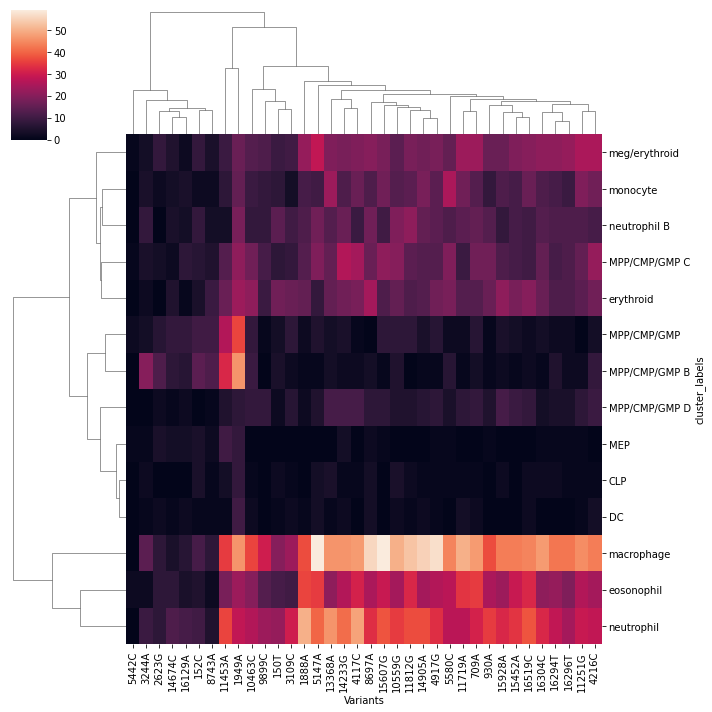

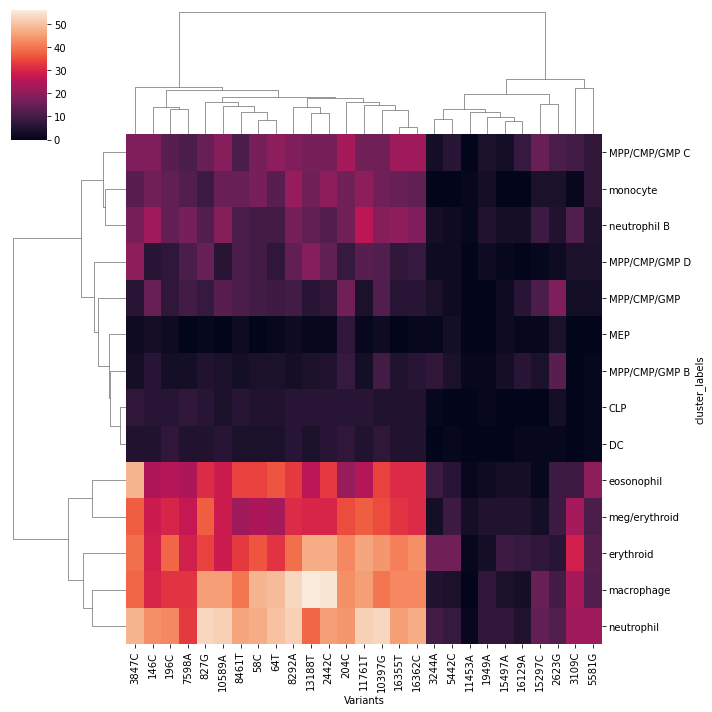

In [9]:
for curr_don, don_lin_mt_ncells in lin_mt_ncells.groupby("donor"):
    curr_don_mt = don_lin_mt_ncells.set_index(["cluster_labels","donor"])
    #lin_mt_ncells_w = curr_don_mt.reset_index().melt(id_vars=["cluster_labels", "donor"], var_name="Variant", value_name="ncells")
    don_lin_mt_ncells_df = don_lin_mt_ncells.pivot(index="cluster_labels", columns="Variants", values=0 )
    sns.clustermap(don_lin_mt_ncells_df.fillna(0))

## Normalize to each column

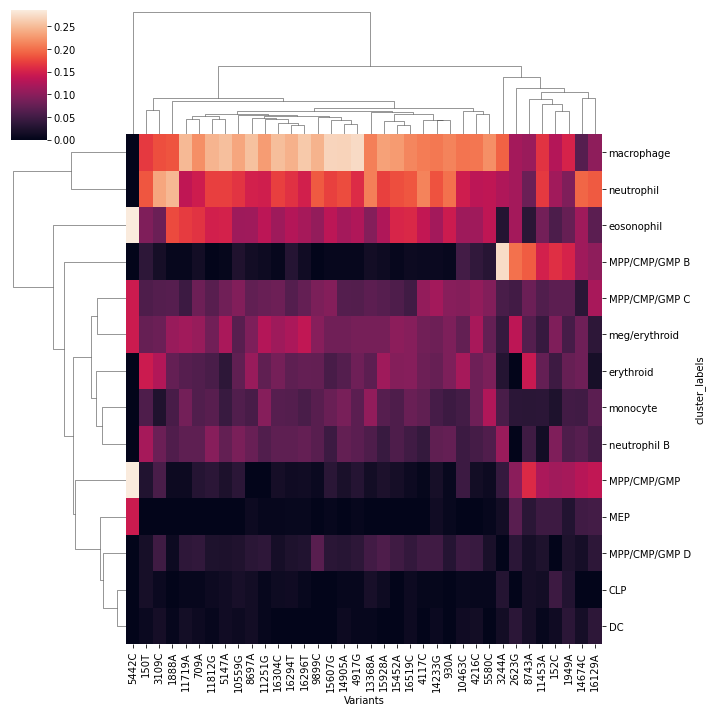

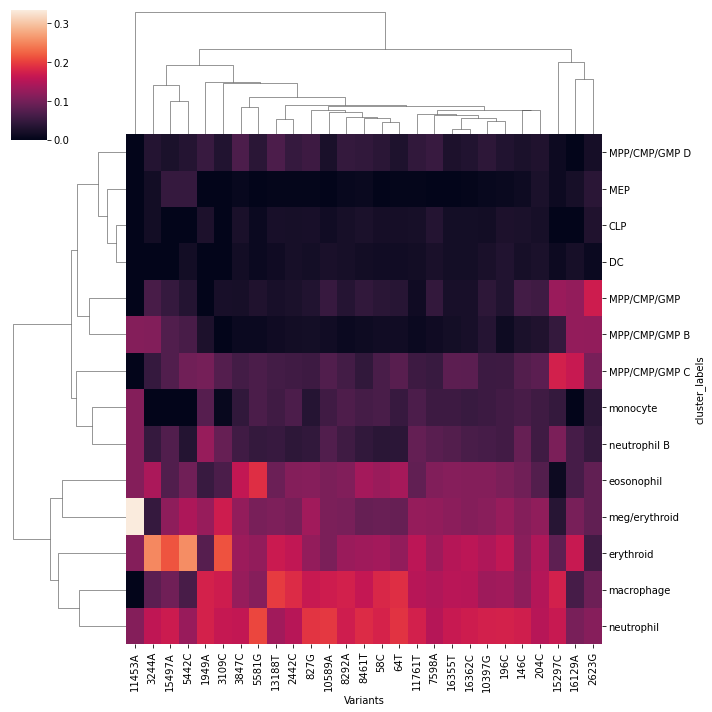

In [11]:
for curr_don, don_lin_mt_ncells in lin_mt_ncells.groupby("donor"):
    curr_don_mt = don_lin_mt_ncells.set_index(["cluster_labels","donor"])
    #lin_mt_ncells_w = curr_don_mt.reset_index().melt(id_vars=["cluster_labels", "donor"], var_name="Variant", value_name="ncells")
    don_lin_mt_ncells_df = don_lin_mt_ncells.pivot(index="cluster_labels", columns="Variants", values=0 )
    don_lin_mt_ncells_df = don_lin_mt_ncells_df/don_lin_mt_ncells_df.sum(axis=0)
    sns.clustermap(don_lin_mt_ncells_df.fillna(0))

## Normalize to each row

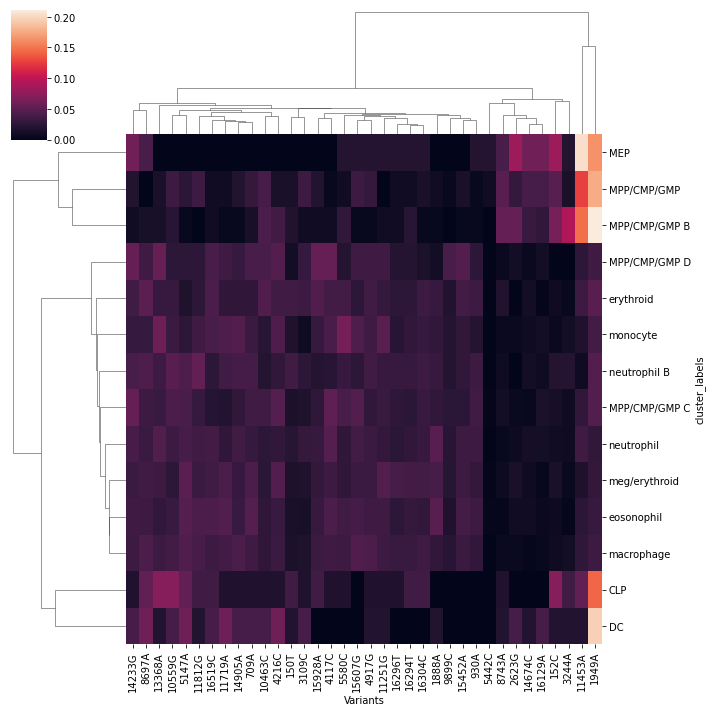

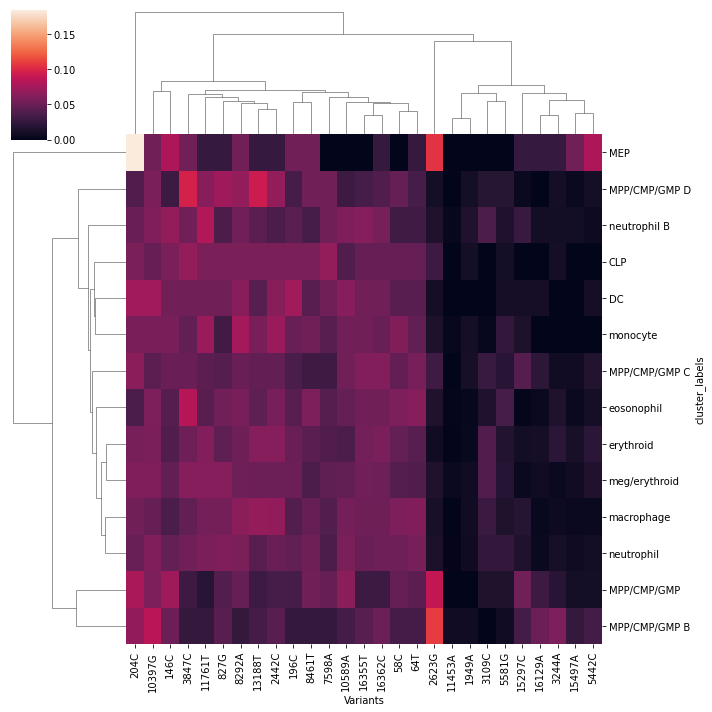

In [25]:
for curr_don, don_lin_mt_ncells in lin_mt_ncells.groupby("donor"):
    curr_don_mt = don_lin_mt_ncells.set_index(["cluster_labels","donor"])
    #lin_mt_ncells_w = curr_don_mt.reset_index().melt(id_vars=["cluster_labels", "donor"], var_name="Variant", value_name="ncells")
    don_lin_mt_ncells_df = don_lin_mt_ncells.pivot(index="cluster_labels", columns="Variants", values=0 )

    tot_cells_clust = don_lin_mt_ncells_df.sum(axis=1)
    don_lin_mt_ncells_df = don_lin_mt_ncells_df.apply(lambda x: x/tot_cells_clust.loc[x.name], axis=1)
    #don_lin_mt_ncells_df = don_lin_mt_ncells_df/(don_lin_mt_ncells_df.sum(axis=1))
    sns.clustermap(don_lin_mt_ncells_df.fillna(0))